# 네이버 영화리뷰 감정분석 with Hugging Face BERT

네이버 영화 리뷰 감정분석 with Hugging Face Bert
Transformers 라는 기계번역 모델의 Encoder 구조를 갖는 기계번역 모델이다. 
즉, Transformers 라는 모델의 일부분을 사용하고 성능을 업그레이드한 모델이 BERT인 것이다.
(1) Transformer란?
위 Abstract에서도 알 수 있듯이 BERT는 Transformer 라는 모델의 인코더 구조를 여러 층으로 쌓은 형태의 구조를 가지고 있는데,
아래 이미지는 Transformer 모델의 구조로, 왼쪽에는 인코더 역할을 하는 구조와 오른쪽에는 디코더 역할을 하는 구조를 갖고 있다. 
따라서 BERT는 Transformer의 인코더 구조를 이용하기 때문에 왼쪽 부분의 구조만을 이용한다.


In [5]:
import tensorflow as tf
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
import time
import datetime



ModuleNotFoundError: No module named 'tensorflow'

# 데이터 로드

In [6]:
# 네이버 영화리뷰 감정분석 데이터 다운로드
git clone https://github.com/e9t/nsmc.git

Cloning into 'nsmc'...
fatal: write error: No space left on device
fatal: fetch-pack: invalid index-pack output


박은정님의 네이버 영화리뷰 감정분석 데이터를 Github에서 다운로드 합니다. 아래와 같이 nsmc 디렉토리에 있는 ratings_train.txt와 ratings_test.txt를 사용하겠습니다.

In [7]:
# 디렉토리의 파일 목록
!ls nsmc -la

'ls'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [8]:
# 판다스로 훈련셋과 테스트셋 데이터 로드
train = pd.read_csv("nsmc/ratings_train.txt", sep='\t')
test = pd.read_csv("nsmc/ratings_test.txt", sep='\t')

print(train.shape)
print(test.shape)

NameError: name 'pd' is not defined

훈련셋 150,000개와 테스트셋 50,000개의 데이터가 존재합니다.

In [15]:
# 훈련셋의 앞부분 출력
train.head(10)

NameError: name 'train' is not defined

id는 회원정보, document는 리뷰 문장입니다. label이 0이면 부정, 1이면 긍정으로 분류됩니다. id는 사용하지 않기 때문에 document와 label만 추출하겠습니다.

# 전처리 - 훈련셋

In [14]:
# 리뷰 문장 추출
sentences = train['document']
sentences[:10]

NameError: name 'train' is not defined

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [16]:
# BERT의 입력 형식에 맞게 변환
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
sentences[:10]

NameError: name 'sentences' is not defined

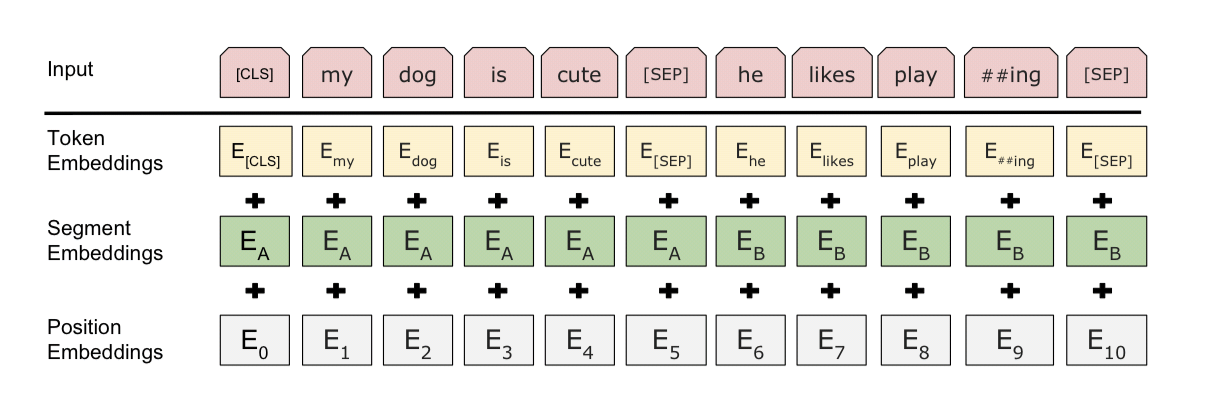
BERT의 입력은 위의 그림과 같은 형식입니다. Classification을 뜻하는 [CLS] 심볼이 제일 앞에 삽입됩니다. 파인튜닝시 출력에서 이 위치의 값을 사용하여 분류를 합니다. [SEP]은 Seperation을 가리키는데, 두 문장을 구분하는 역할을 합니다. 이 예제에서는 문장이 하나이므로 [SEP]도 하나만 넣습니다.

In [17]:
# 라벨 추출
labels = train['label'].values
labels

NameError: name 'train' is not defined

In [18]:
# BERT의 토크나이저로 문장을 토큰으로 분리
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

print (sentences[0])
print (tokenized_texts[0])

NameError: name 'BertTokenizer' is not defined

BERT는 형태소분석으로 토큰을 분리하지 않습니다. WordPiece라는 통계적인 방식을 사용합니다. 한 단어내에서 자주 나오는 글자들을 붙여서 하나의 토큰으로 만듭니다. 이렇게 하면 언어에 상관없이 토큰을 생성할 수 있다는 장점이 있습니다. 또한 신조어 같이 사전에 없는 단어를 처리하기도 좋습니다.

위의 결과에서 ## 기호는 앞 토큰과 이어진다는 표시입니다. 토크나이저는 여러 언어의 데이터를 기반으로 만든 'bert-base-multilingual-cased'를 사용합니다. 그래서 한글도 처리가 가능합니다.

In [20]:
# 입력 토큰의 최대 시퀀스 길이
MAX_LEN = 128

# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

input_ids[0]

NameError: name 'tokenized_texts' is not defined

보통 딥러닝 모델에는 토큰 자체를 입력으로 넣을 수 없습니다. 임베딩 레이어에는 토큰을 숫자로 된 인덱스로 변환하여 사용합니다. BERT의 토크나이저는 {단어토큰:인덱스}로 구성된 단어사전을 가지고 있습니다. 이를 참조하여 토큰을 인덱스로 바꿔줍니다.

In [21]:
# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])

NameError: name 'input_ids' is not defined

In [23]:
# 훈련셋과 검증셋으로 분리
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,
                                                                                    labels, 
                                                                                    random_state=2018, 
                                                                                    test_size=0.1)

# 어텐션 마스크를 훈련셋과 검증셋으로 분리
train_masks, validation_masks, _, _ = train_test_split(attention_masks, 
                                                       input_ids,
                                                       random_state=2018, 
                                                       test_size=0.1)

# 데이터를 파이토치의 텐서로 변환
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)				

print(train_inputs[0])
print(train_labels[0])
print(train_masks[0])
print(validation_inputs[0])
print(validation_labels[0])
print(validation_masks[0])

NameError: name 'train_test_split' is not defined

In [25]:
# 배치 사이즈
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

NameError: name 'TensorDataset' is not defined

# 전처리 - 테스트셋

In [27]:
# 리뷰 문장 추출
sentences = test['document']
sentences[:10]

NameError: name 'test' is not defined

In [28]:
# BERT의 입력 형식에 맞게 변환
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
sentences[:10]

NameError: name 'sentences' is not defined

In [30]:
# 라벨 추출
labels = test['label'].values
labels

NameError: name 'test' is not defined

In [31]:
# BERT의 토크나이저로 문장을 토큰으로 분리
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

print (sentences[0])
print (tokenized_texts[0])

NameError: name 'BertTokenizer' is not defined

In [32]:
# 입력 토큰의 최대 시퀀스 길이
MAX_LEN = 128

# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

input_ids[0]

NameError: name 'tokenized_texts' is not defined

In [33]:
# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])

NameError: name 'input_ids' is not defined

In [34]:
# 데이터를 파이토치의 텐서로 변환
test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

print(test_inputs[0])
print(test_labels[0])
print(test_masks[0])

NameError: name 'torch' is not defined

In [36]:
# 배치 사이즈
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

NameError: name 'TensorDataset' is not defined

# 모델 생성

In [37]:
# GPU 디바이스 이름 구함
device_name = tf.test.gpu_device_name()

# GPU 디바이스 이름 검사
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

NameError: name 'tf' is not defined

In [38]:
# 디바이스 설정
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

NameError: name 'torch' is not defined

In [40]:
# 분류를 위한 BERT 모델 생성
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
model.cuda()

NameError: name 'BertForSequenceClassification' is not defined

대체 텍스트
사전훈련된 BERT는 다양한 문제로 전이학습이 가능합니다. 여기서는 위의 그림과 같이 한 문장을 분류하는 방법을 사용합니다. 영화리뷰 문장이 입력으로 들어가면, 긍정/부정으로 구분합니다. 모델의 출력에서 [CLS] 위치인 첫 번째 토큰에 새로운 레이어를 붙여서 파인튜닝을 합니다. Huggning Face는 BertForSequenceClassification() 함수를 제공하기 때문에 쉽게 구현할 수 있습니다.

In [42]:
# 옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

# 에폭수
epochs = 4

# 총 훈련 스텝 : 배치반복 횟수 * 에폭
total_steps = len(train_dataloader) * epochs

# 처음에 학습률을 조금씩 변화시키는 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

NameError: name 'AdamW' is not defined

# 모델 학습

In [43]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [44]:
# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [45]:
# 재현을 위해 랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 그래디언트 초기화
model.zero_grad()

# 에폭만큼 반복
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()
        
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # Forward 수행                
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # 로스 구함
        loss = outputs[0]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        
        # 그래디언트 계산 안함
        with torch.no_grad():     
            # Forward 수행
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # 출력 로짓 구함
        logits = outputs[0]

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")

NameError: name 'random' is not defined

에폭마다 훈련셋과 검증셋을 반복하여 학습을 수행합니다. 

# 테스트셋 평가

In [46]:
#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_dataloader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)
    
    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch
    
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # 출력 로짓 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))

NameError: name 'time' is not defined

테스트셋의 정확도가 87%입니다. <BERT 톺아보기> 블로그에서는 같은 데이터로 88.7%를 달성하였습니다. 거기서는 한글 코퍼스로 사전훈련을 하여 새로운 모델을 만들었습니다. 반면에 우리는 BERT의 기본 모델인 bert-base-multilingual-cased를 사용했기 때문에 더 성능이 낮은 것 같습니다.

# 새로운 문장 테스트

In [47]:
# 입력 데이터 변환
def convert_input_data(sentences):

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이
    MAX_LEN = 128

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    
    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

In [48]:
# 문장 테스트
def test_sentences(sentences):

    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
            
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # 출력 로짓 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()

    return logits

In [49]:
logits = test_sentences(['연기는 별로지만 재미 하나는 끝내줌!'])

print(logits)
print(np.argmax(logits))

NameError: name 'model' is not defined

In [51]:
logits = test_sentences(['주연배우가 아깝다. 총체적 난국...'])

print(logits)
print(np.argmax(logits))

NameError: name 'model' is not defined

학습한 모델을 가지고 실제 문장을 넣어봤습니다. 출력 로짓은 소프트맥스가 적용되지 않은 상태입니다. argmax로 더 높은 값의 위치를 라벨로 설정하면 됩니다. 0은 부정, 1은 긍정입니다. 위와 같이 새로운 문장에도 잘 분류를 하고 있습니다.